In [1]:
# Allows us to import packages that exist one level up in the file system
# See https://stackoverflow.com/questions/34478398
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from tagnews.utils import load_data as ld
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.feature_extraction.text
import sklearn.multiclass
import sklearn.linear_model
% matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8

In [3]:
df = ld.load_data()

KeyboardInterrupt: 

In [4]:
# TODO: Augment training data with not relevant

In [4]:
crime_df = df.ix[df.loc[:, 'OEMC':'TASR'].any(1), :]
print(crime_df.shape)
crime_df = crime_df.append(df.ix[~df['relevant'], :].sample(n=3000, axis=0))
print(crime_df.shape)

idx = np.random.permutation(crime_df.shape[0])
trn = crime_df.iloc[idx[:int(crime_df.shape[0] * 0.7)], :]
tst = crime_df.iloc[idx[int(crime_df.shape[0] * 0.7):], :]
print(trn.shape)
print(tst.shape)

/Users/perfecthair/anaconda/envs/cjp-ap/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


(39709, 50)
(42709, 50)
(29896, 50)
(12813, 50)


In [5]:
# vectorize data
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

vectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer=LemmaTokenizer(),
                                                             binary=True)
X = vectorizer.fit_transform(trn['bodytext'].values)

Y = trn.loc[:, 'OEMC':'TASR'].values

In [6]:
X.shape

(29896, 221436)

In [7]:
from tagnews.crimetype import benchmark as bt

In [8]:
bench_results = bt.benchmark(
    lambda: sklearn.multiclass.OneVsRestClassifier(
        sklearn.linear_model.LogisticRegression()
    ),
    vectorizer.transform(crime_df['bodytext'].values),
    crime_df.loc[:, 'OEMC':'TASR'].values
)

In [9]:
fpr = pd.DataFrame(bench_results['fpr'], columns=df.loc[:, 'OEMC':'TASR'].columns.values).T

tpr = pd.DataFrame(bench_results['tpr'], columns=df.loc[:, 'OEMC':'TASR'].columns.values).T

ppv = pd.DataFrame(bench_results['ppv'], columns=df.loc[:, 'OEMC':'TASR'].columns.values).T

In [17]:
fpr

,0,1,2,3
OEMC,0.000282,0.000094,0.000470,0.000000
CPD,0.182553,0.175043,0.169148,0.159024
SAO,0.021592,0.021454,0.026471,0.024321
CCCC,0.023379,0.020006,0.018655,0.018253
CCJ,0.004213,0.005167,0.004390,0.003652
CCSP,0.008258,0.006515,0.006298,0.006206
CPUB,0.000848,0.000377,0.000377,0.000847
IDOC,0.000849,0.001510,0.001225,0.001227
DOMV,0.009994,0.009960,0.009379,0.009985
SEXA,0.005004,0.005699,0.006289,0.006565


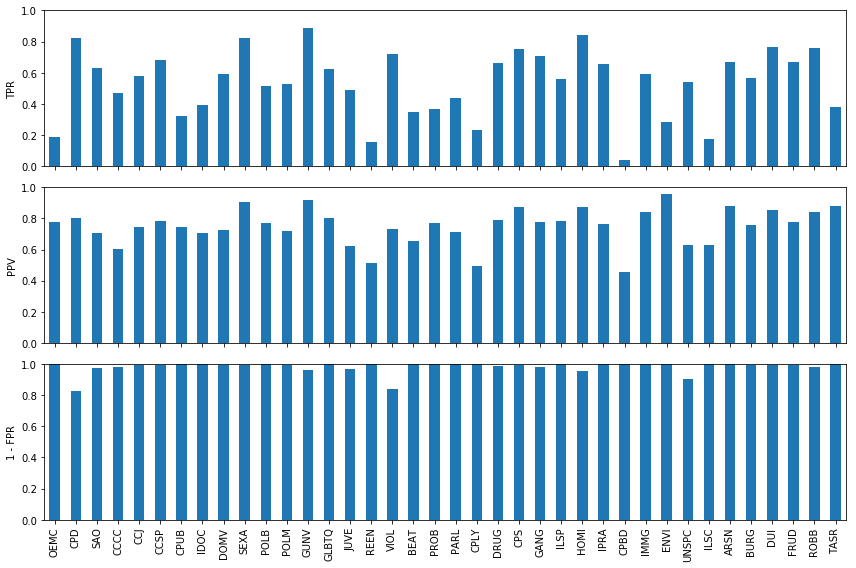

In [11]:
f, axs = plt.subplots(3,1)
tpr.mean(axis=1).plot(kind='bar', ax=axs[0])
axs[0].set_ylabel('TPR')
axs[0].set_xticklabels([])
axs[0].set_ylim([0, 1])
ppv.mean(axis=1).plot(kind='bar', ax=axs[1])
axs[1].set_ylabel('PPV')
axs[1].set_xticklabels([])
axs[1].set_ylim([0, 1])
(1 - fpr).mean(axis=1).plot(kind='bar', ax=axs[2])
axs[2].set_ylabel('1 - FPR')
axs[2].set_ylim([0, 1])
plt.tight_layout()
plt.show()

In [12]:
df.loc[:, 'OEMC'::].columns

Index(['OEMC', 'CPD', 'SAO', 'CCCC', 'CCJ', 'CCSP', 'CPUB', 'IDOC', 'DOMV',
       'SEXA', 'POLB', 'POLM', 'GUNV', 'GLBTQ', 'JUVE', 'REEN', 'VIOL', 'BEAT',
       'PROB', 'PARL', 'CPLY', 'DRUG', 'CPS', 'GANG', 'ILSP', 'HOMI', 'IPRA',
       'CPBD', 'IMMG', 'ENVI', 'UNSPC', 'ILSC', 'ARSN', 'BURG', 'DUI', 'FRUD',
       'ROBB', 'TASR', 'COPA', 'DIGP'],
      dtype='object')

In [13]:
# this will write 10 files to the notebooks directory
bt.predict_articles(bench_results['clfs'][0], vectorizer, df, n=10)

In [14]:
# sanity check
clf = bench_results['clfs'][0]
pd.DataFrame(
    clf.predict_proba(vectorizer.transform(['marijuana'])),
    columns=df.loc[:, 'OEMC':'TASR'].columns
).T.sort_values(0, ascending=False)

,0
DRUG,0.880031
CPS,0.291266
ENVI,0.238325
UNSPC,0.217670
TASR,0.200393
CPD,0.198556
GLBTQ,0.198409
IMMG,0.197271
OEMC,0.197144
CPUB,0.189414


In [15]:
not_yet_tagged = df.loc[df['relevant'] & ~df.loc[:, 'OEMC':'TASR'].any(1), :]

In [16]:
not_yet_tagged_preds = pd.DataFrame(
    clf.predict_proba(vectorizer.transform(not_yet_tagged.loc[:, 'bodytext'].values)),
    columns=df.loc[:, 'OEMC':'TASR'].columns
)

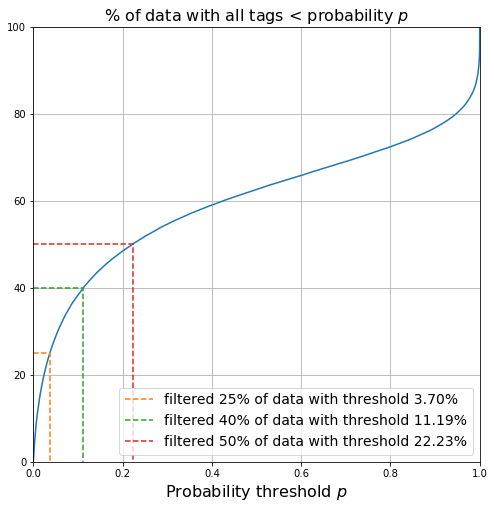

In [18]:
f, ax = plt.subplots(1, figsize=(8,8))
percents = not_yet_tagged_preds.max(axis=1).sort_values().reset_index().values[:,1]
filtered = np.linspace(0, 100, not_yet_tagged_preds.shape[0])

ax.plot(percents, filtered)

for filtered_p in [25, 40, 50]:
    p = percents[np.where(filtered >= filtered_p)[0][0]]
    plt.plot([0, p, p],
             [filtered_p, filtered_p, 0],
             '--',
             label='filtered {}% of data with threshold {:.2%}'.format(filtered_p, p))

ax.grid(True)
ax.set_xlim([0, 1])
ax.set_ylim([0, 100])
ax.set_xlabel('Probability threshold $p$', fontsize=16)
ax.set_title('% of data with all tags < probability $p$', fontsize=16)
ax.legend(loc='lower right', fontsize=14)

In [19]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(bench_results['clfs'][0], f)
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)